In [32]:
#Standard libraries
import math
import datetime, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from scipy import interp

#Used to create dictionaries IOCs
from collections import OrderedDict


#tools for reducing files
from itertools import cycle
from functools import reduce

#Navigate directories
import os

#Scikit-learn
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.model_selection import (StratifiedKFold, train_test_split, GridSearchCV, KFold, 
                                     cross_validate, cross_val_score, cross_val_predict)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

#Experimental classifier
import xgboost as xgb

#from tokenizer import Tokenizer

# Import Data

In [12]:
redteam_data_names = ['time','user@domain','src_comp','dest_comp']
redteam_data = pd.read_csv('/users7/csegrad/smillett/capstone/Dataset/redteam.txt',names = redteam_data_names, 
                           header=None)

In [5]:
proc_data = pd.read_csv('/users7/csegrad/smillett/capstone/Dataset/reduced_proc.csv')

In [9]:
auth_data = pd.read_csv('/users7/csegrad/smillett/capstone/Dataset/reduced_auth.csv')

In [7]:
dns_data = pd.read_csv('/users7/csegrad/smillett/capstone/Dataset/reduced_dns.csv')

In [ ]:
flows_data = pd.read_csv('/users7/csegrad/smillett/capstone/Dataset/reduced_flows.csv')

# Preprocess Data

## Redteam data

In [10]:
redteam_data.head()

,time,user@domain,src_comp,dest_comp
0,150885,U620@DOM1,C17693,C1003
1,151036,U748@DOM1,C17693,C305
2,151648,U748@DOM1,C17693,C728
3,151993,U6115@DOM1,C17693,C1173
4,153792,U636@DOM1,C17693,C294


In [26]:
redteam_data['src_user'] = redteam_data['user@domain'].str.split('@',n=1,expand=True)[0]
redteam_data['src_domain'] = redteam_data['user@domain'].str.split('@',n=1,expand=True)[1]

redteam_data.drop(['user@domain'],axis='columns',inplace=True)

In [27]:
redteam_data.head()

,time,src_comp,dest_comp,src_user,src_domain
0,150885,C17693,C1003,U620,DOM1
1,151036,C17693,C305,U748,DOM1
2,151648,C17693,C728,U748,DOM1
3,151993,C17693,C1173,U6115,DOM1
4,153792,C17693,C294,U636,DOM1


## Proc Data

In [28]:
proc_data.head()

,time,src_comp,proc,start,src_user,src_domain
0,52756,C3326,P265,Start,C3326$,DOM1
1,52756,C449,P137,Start,C449$,DOM1
2,52756,C449,P16,Start,C449$,DOM1
3,52756,C520,P16,Start,C520$,DOM1
4,52756,C5362,P267,Start,C5362$,DOM1


In [ ]:
proc_data['src_user'] = proc_data['user@domain'].str.split('@',n=1,expand=True)[0]
proc_data['src_domain'] = proc_data['user@domain'].str.split('@',n=1,expand=True)[1]

proc_data.drop(['user@domain'],axis='columns',inplace=True)

In [24]:
#proc_groups = OrderedDict

In [63]:
proc_start = proc_data[['start','src_comp','time']][proc_data["start"]=='Start'].groupby(['time','src_comp']).count()
proc_end = proc_data[['start','src_comp','time']][proc_data["start"]=='End'].groupby(['time','src_comp']).count()

In [64]:
proc_end.rename(columns={'start':'end'},inplace=True)

In [65]:
proc_end.reset_index(inplace=True)
proc_start.reset_index(inplace=True)

In [70]:
result = pd.merge(proc_end,proc_start,how='outer',on=['time','src_comp']).fillna(0)

In [72]:
result.head(10)

,time,src_comp,end,start
0,52756,C12837,1.0,0.0
1,52756,C13012,1.0,0.0
2,52756,C1972,1.0,0.0
3,52756,C3430,1.0,0.0
4,52756,C589,1.0,0.0
5,52756,C6213,1.0,0.0
6,52756,C629,1.0,1.0
7,52756,C6687,4.0,1.0
8,52757,C101,1.0,0.0
9,52757,C12330,1.0,1.0


In [25]:
proc_data.head()

,time,src_comp,proc,start,src_user,src_domain
0,52756,C3326,P265,Start,C3326$,DOM1
1,52756,C449,P137,Start,C449$,DOM1
2,52756,C449,P16,Start,C449$,DOM1
3,52756,C520,P16,Start,C520$,DOM1
4,52756,C5362,P267,Start,C5362$,DOM1


## Auth Data

In [11]:
auth_data.head()

,time,user@domain,dest_user@domain,src_comp,dest_comp,auth_type,logon_type,auth_orient,success
0,56816,C2341$@DOM1,C2341$@DOM1,C2341,C467,Kerberos,Network,LogOn,Success
1,56816,C2341$@DOM1,C2341$@DOM1,C2341,C528,Kerberos,Network,LogOn,Success
2,56816,C2341$@DOM1,C2341$@DOM1,C2341,C529,?,?,TGS,Success
3,56816,C2341$@DOM1,C2341$@DOM1,C2341,C529,Kerberos,Network,LogOn,Success
4,56816,C2341$@DOM1,C2341$@DOM1,C2341,C612,Kerberos,Network,LogOn,Success


In [ ]:
auth_data['src_user'] = auth_data['user@domain'].str.split('@',n=1,expand=True)[0]
auth_data['src_domain'] = auth_data['user@domain'].str.split('@',n=1,expand=True)[1]

auth_data['dest_user'] = auth_data['dest_user@domain'].str.split('@',n=1,expand=True)[0]
auth_data['dest_domain'] = auth_data['dest_user@domain'].str.split('@',n=1,expand=True)[1]

auth_data.drop(['user@domain','dest_user@domain'],axis='columns',inplace=True)

In [78]:
fail_logon = auth_data[['time','src_comp','auth_orient','success']][(auth_data['auth_orient']=='LogOn') & (auth_data['success']=='Fail')].groupby(['time','src_comp']).count()
TGS_count = auth_data[['time','src_comp','auth_orient']][(auth_data['auth_orient']=='TGS')].groupby(['time','src_comp']).count()
TGT_count = auth_data[['time','src_comp','auth_orient']][(auth_data['auth_orient']=='TGT')].groupby(['time','src_comp']).count()

In [80]:
TGT_count.head(20)

auth_orient
time  src_comp             
56816 C105                1
      C13742              1
      C1392               1
      C1710               1
56817 C1795               1
      C2093               1
      C2323               1
      C2366               1
      C2681               1
      C5850               1
      C6273               1
      C6817               1
      C775                1
56818 C12552              1
      C1618               1
      C1621               1
      C2398               1
      C2404               1
      C2412               1
      C2742               1

In [29]:
auth_data.head(10)

,time,src_comp,dest_comp,auth_type,logon_type,auth_orient,success,src_usr,src_user,src_domain,dest_user,dest_domain
0,56816,C2341,C467,Kerberos,Network,LogOn,Success,C2341$,C2341$,DOM1,C2341$,DOM1
1,56816,C2341,C528,Kerberos,Network,LogOn,Success,C2341$,C2341$,DOM1,C2341$,DOM1
2,56816,C2341,C529,?,?,TGS,Success,C2341$,C2341$,DOM1,C2341$,DOM1
3,56816,C2341,C529,Kerberos,Network,LogOn,Success,C2341$,C2341$,DOM1,C2341$,DOM1
4,56816,C2341,C612,Kerberos,Network,LogOn,Success,C2341$,C2341$,DOM1,C2341$,DOM1
5,56816,C457,C457,?,Network,LogOff,Success,C2341$,C2341$,DOM1,C2341$,DOM1
6,56816,C529,C529,?,Network,LogOff,Success,C2341$,C2341$,DOM1,C2341$,DOM1
7,56816,C2368,C1881,Kerberos,Network,LogOn,Success,C2368$,C2368$,DOM1,C2368$,DOM1
8,56816,C625,C625,?,Network,LogOff,Success,C2415$,C2415$,DOM1,C2415$,DOM1
9,56816,C625,C625,?,Network,LogOff,Success,C2489$,C2489$,DOM1,C2489$,DOM1


## DNS Data

In [13]:
dns_data.head()

,time,src_comp,comp_rslv
0,86263,C2492,C457
1,86263,C3484,C1685
2,86264,C6758,C1707
3,86266,C6509,C5030
4,86267,C5332,C528


In [15]:
dns_data.head()

,time,src_comp,comp_rslv
0,86263,C2492,C457
1,86263,C3484,C1685
2,86264,C6758,C1707
3,86266,C6509,C5030
4,86267,C5332,C528


## Flows Data

In [30]:
flows_data.head()

,time,dur,src_comp,src_port,dest_comp,dest_port,protocol,pkt_cnt,byte_cnt
0,80172,60,C3422,1433,C5756,N3966,6,3,138
1,80172,7,C1685,N78,C11779,N2267,6,8,3203
2,80172,7,C1685,N78,C11904,N25330,6,8,3203
3,80173,0,C1685,N78,C24057,N20573,6,5,425
4,80173,0,C24057,N20573,C1685,N78,6,7,1746


In [ ]:
flows_data.head()

# Combine Data

In [14]:
mlb = MultiLabelBinarizer()
df = proc_data.join(pd.DataFrame(mlb.fit_transform(proc_data['proc']),
                                columns = mlb.classes_,
                                index=proc_data.index))

In [21]:
df.shape

(17041800, 16)

In [15]:
df = df.drop_duplicates()

In [23]:
df.shape

(17041800, 16)

In [16]:
test = redteam_data[['time','dest_comp']].merge(df, left_on=['time','dest_comp'],right_on=['time','src_comp'],suffixes=['_red','_proc'],how='right')

In [40]:
test.shape

(17041800, 17)

In [17]:
new_test = test.drop_duplicates(['time','user@domain_red','user@domain_proc','src_comp_proc','proc'])

In [38]:
new_test.head()

,time,user@domain_red,src_comp_red,dest_comp,user@domain_proc,src_comp_proc,proc,start,0,1,2,3,4,5,6,7,8,9,P
0,153792,U636@DOM1,C17693,C294,C294$@DOM1,C294,P4,Start,0,0,0,0,1,0,0,0,0,0,1
1,153792,U636@DOM1,C17693,C294,C294$@DOM1,C294,P8311,Start,0,1,0,1,0,0,0,0,1,0,1
2,155591,U748@DOM1,C17693,C332,C332$@DOM1,C332,P4,Start,0,0,0,0,1,0,0,0,0,0,1
3,155591,U748@DOM1,C17693,C332,C332$@DOM1,C332,P8319,Start,0,1,0,1,0,0,0,0,1,1,1
4,218418,U748@DOM1,C17693,C504,C504$@DOM1,C504,P245,End,0,0,1,0,1,1,0,0,0,0,1


In [24]:
label_encode = LabelEncoder()
trans = label_encode.fit_transform(test['start'])
onehot = OneHotEncoder()
trans = trans.reshape(len(trans),1)
new_batch = onehot.fit_transform(trans)

#test = 

  (0, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 1)	1.0
  (7, 1)	1.0
  (8, 1)	1.0
  (9, 1)	1.0
  (10, 1)	1.0
  (11, 1)	1.0
  (12, 1)	1.0
  (13, 1)	1.0
  (14, 1)	1.0
  (15, 1)	1.0
  (16, 1)	1.0
  (17, 1)	1.0
  (18, 0)	1.0
  (19, 1)	1.0
  (20, 1)	1.0
  (21, 1)	1.0
  (22, 1)	1.0
  (23, 1)	1.0
  (24, 1)	1.0
  :	:
  (17041775, 1)	1.0
  (17041776, 1)	1.0
  (17041777, 1)	1.0
  (17041778, 1)	1.0
  (17041779, 1)	1.0
  (17041780, 1)	1.0
  (17041781, 1)	1.0
  (17041782, 1)	1.0
  (17041783, 0)	1.0
  (17041784, 1)	1.0
  (17041785, 0)	1.0
  (17041786, 1)	1.0
  (17041787, 0)	1.0
  (17041788, 1)	1.0
  (17041789, 0)	1.0
  (17041790, 1)	1.0
  (17041791, 1)	1.0
  (17041792, 1)	1.0
  (17041793, 1)	1.0
  (17041794, 1)	1.0
  (17041795, 1)	1.0
  (17041796, 0)	1.0
  (17041797, 1)	1.0
  (17041798, 1)	1.0
  (17041799, 1)	1.0


In [32]:
new_test = test.copy()
new_test['start'] = pd.get_dummies(new_test['start'],drop_first=True)

In [65]:
y = [0 if pd.isnull(x) else 1 for x in new_test['dest_comp']]
y = np.asarray(y)

In [69]:
X = new_test.drop(['time','dest_comp','user@domain','src_comp','proc'],axis=1)
X = np.asarray(X)

# Create Classification model

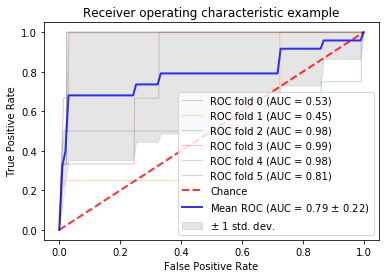

In [70]:
cv = StratifiedKFold(n_splits=6)
classifier = SVC(kernel='linear', probability=True)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [53]:
fpr,tpr, thresholds = roc_curve(y_test,classifier.predict_proba(X_test)[:,1])

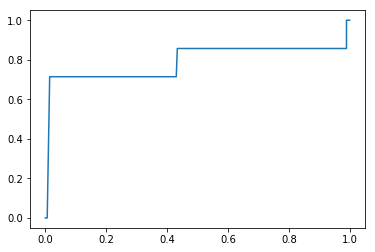

In [54]:
plt.plot(fpr,tpr)

# Don't run any of this code

In [ ]:
import pyspark as spark
from pyspark.conf import SparkConf
from pyspark.sql.types import (StructField, StringType,FloatType, 
                               DoubleType, IntegerType, StructType,
                              DateType)
from pyspark.sql import functions as F
from pyspark.sql import DataFrame as spDataFrame
from pyspark.ml.feature import Binarizer, OneHotEncoder, StringIndexer

In [10]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName('Intrusion Detection') \
        .config('spark.some.config.option','some-value') \
        .getOrCreate()

## Import DATA

In [11]:
proc_data_schema = [StructField('time',IntegerType(),True),
                   StructField('user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('proc_name',StringType(),True),
                   StructField('strt',StringType())]
proc_final_struc = StructType(fields = proc_data_schema)
proc = spark.read.csv('/users7/csegrad/smillett/capstone/Dataset/reduced_proc.csv',schema=proc_final_struc)

auth_data_schema = [StructField('time',IntegerType(),True),
                   StructField('src_user@domain',StringType(),True),
                   StructField('dest_user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('dest_comp',StringType(),True),
                   StructField('auth_type',StringType(),True),
                   StructField('logon_type',StringType(),True),
                   StructField('auth_orient',StringType(),True),
                   StructField('success',StringType(),True)]
auth_final_struc = StructType(fields = auth_data_schema)
auth = spark.read.csv('/users7/csegrad/smillett/capstone/Dataset/reduced_auth.csv',schema=auth_final_struc )

flows_data_schema = [StructField('time',IntegerType(),False),
                   StructField('dur',IntegerType(),False),
                   StructField('src_comp',StringType(),False),
                   StructField('src_port',StringType(),False),
                   StructField('dest_comp',StringType(),False),
                   StructField('dest_port',StringType(),False),
                   StructField('protocol',StringType(),False),
                   StructField('pkt_cnt',IntegerType(),False),
                   StructField('byte_cnt',IntegerType(),False)]
flows_final_struc = StructType(fields = flows_data_schema)
flows = spark.read.csv('/users7/csegrad/smillett/capstone/Dataset/reduced_flows.csv',schema=flows_final_struc )

dns_data_schema = [StructField('time',IntegerType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('cmp_resolved',StringType(),True)]
dns_final_struc = StructType(fields = dns_data_schema)
dns = spark.read.csv('/users7/csegrad/smillett/capstone/Dataset/reduced_dns.csv',schema=dns_final_struc)

redteam_data_schema = [StructField('time',IntegerType(),True),
                   StructField('user@domain',StringType(),True),
                   StructField('src_comp',StringType(),True),
                   StructField('dest_comp',StringType(),True)]
redteam_final_struc = StructType(fields = redteam_data_schema)
redteam = spark.read.csv('/users7/csegrad/smillett/capstone/Dataset/redteam.txt',schema=redteam_final_struc)

## Transform Data

In [12]:
proc_split = F.split(proc['user@domain'],'@')
proc = proc.withColumn('src_user',proc_split.getItem(0))
proc = proc.withColumn('src_dmn',proc_split.getItem(1))
proc = proc.drop('user@domain')

proc = proc.withColumn('type',F.lit('Process'))

In [13]:
auth_src_split = F.split(auth['src_user@domain'],'@')
auth = auth.withColumn('src_user',auth_src_split.getItem(0))
auth = auth.withColumn('src_dmn',auth_src_split.getItem(1))

auth_dest_split = F.split(auth['dest_user@domain'],'@')
auth = auth.withColumn('dest_user',auth_dest_split.getItem(0))
auth = auth.withColumn('dest_dmn',auth_dest_split.getItem(1))

auth = auth.drop('src_user@domain','dest_user@domain')

auth = auth.withColumn('type',F.lit('Auth'))

In [14]:
redteam_split = F.split(redteam['user@domain'],'@')
redteam = redteam.withColumn('src_user',redteam_split.getItem(0))
redteam = redteam.withColumn('src_dmn',redteam_split.getItem(1))

redteam = redteam.drop('user@domain')

redteam = redteam.withColumn('type',F.lit('RedTeam'))

In [15]:

flows = flows.withColumn('avg_pkt_size', (flows['byte_cnt']/flows['pkt_cnt']).cast(DoubleType()))
flows = flows.na.drop(how='all')

flows = flows.withColumn('type',F.lit('DataFlow'))

In [30]:
# colum = proc.columns
# colum.sort()

# proc = proc.select(colum)
# redteam = redteam.select(colum)
# auth = auth.select(colum)
# flows = flows.select(colum)

In [31]:
# master = unionAll(redteam,auth,proc,flows)

In [32]:
# print(master.count())

In [33]:
# master.select('strt').sort('strt').show()

In [ ]:
redteam1 = redteam.rdd.map(lambda x: (x['time'], time.strftime('%m/%d %H:%M:%S', time.gmtime(x['time']) ))).toDF(['time','timestam'])

## Data Show

In [16]:
auth.show()

+-----+--------+---------+---------+----------+-----------+-------+--------+-------+---------+--------+----+
| time|src_comp|dest_comp|auth_type|logon_type|auth_orient|success|src_user|src_dmn|dest_user|dest_dmn|type|
+-----+--------+---------+---------+----------+-----------+-------+--------+-------+---------+--------+----+
| null|    null|     null|     null|      null|       null|   null|    null|   null|     null|    null|Auth|
|56816|   C2341|     C467| Kerberos|   Network|      LogOn|Success|  C2341$|   DOM1|   C2341$|    DOM1|Auth|
|56816|   C2341|     C528| Kerberos|   Network|      LogOn|Success|  C2341$|   DOM1|   C2341$|    DOM1|Auth|
|56816|   C2341|     C529|        ?|         ?|        TGS|Success|  C2341$|   DOM1|   C2341$|    DOM1|Auth|
|56816|   C2341|     C529| Kerberos|   Network|      LogOn|Success|  C2341$|   DOM1|   C2341$|    DOM1|Auth|
|56816|   C2341|     C612| Kerberos|   Network|      LogOn|Success|  C2341$|   DOM1|   C2341$|    DOM1|Auth|
|56816|    C457|   

In [35]:
redteam.show()

+------+--------+---------+--------+-------+-------+
|  time|src_comp|dest_comp|src_user|src_dmn|   type|
+------+--------+---------+--------+-------+-------+
|150885|  C17693|    C1003|    U620|   DOM1|RedTeam|
|151036|  C17693|     C305|    U748|   DOM1|RedTeam|
|151648|  C17693|     C728|    U748|   DOM1|RedTeam|
|151993|  C17693|    C1173|   U6115|   DOM1|RedTeam|
|153792|  C17693|     C294|    U636|   DOM1|RedTeam|
|155219|  C17693|    C5693|    U748|   DOM1|RedTeam|
|155399|  C17693|     C152|    U748|   DOM1|RedTeam|
|155460|  C17693|    C2341|    U748|   DOM1|RedTeam|
|155591|  C17693|     C332|    U748|   DOM1|RedTeam|
|156658|  C17693|    C4280|    U748|   DOM1|RedTeam|
|210086|  C18025|    C1493|    U748|   DOM1|RedTeam|
|210294|  C18025|    C1493|    U748|   DOM1|RedTeam|
|210312|  C18025|    C1493|    U748|   DOM1|RedTeam|
|218418|  C17693|     C504|    U748|   DOM1|RedTeam|
|227052|  C17693|     C148|    U748|   DOM1|RedTeam|
|227408|  C17693|     C148|    U748|   DOM1|Re

In [36]:
dns.filter((dns['src_comp']=='C17693')).show()

+-------+--------+------------+
|   time|src_comp|cmp_resolved|
+-------+--------+------------+
|2289058|  C17693|       C5808|
|2289207|  C17693|       C5808|
|2289208|  C17693|       C5808|
|2289209|  C17693|       C5808|
|2289210|  C17693|       C5808|
|2289212|  C17693|       C5808|
|2289213|  C17693|       C5808|
|2289216|  C17693|       C5808|
|2289217|  C17693|       C5808|
|2289218|  C17693|       C5808|
|2289219|  C17693|       C5808|
|2289239|  C17693|       C5808|
|2289240|  C17693|       C5808|
|2289241|  C17693|       C5808|
|2289243|  C17693|       C5808|
|2289264|  C17693|       C5808|
|2289266|  C17693|       C5808|
|2289269|  C17693|       C5808|
|2296865|  C17693|      C17679|
|2296867|  C17693|      C17679|
+-------+--------+------------+
only showing top 20 rows



In [14]:
flows.show()

+----+--------+--------+-------+---------+--------+--------+-------+-------+------------+
|time|duration|src_comp|src_prt|dest_comp|dest_prt|protocol|pkt_cnt|byt_cnt|avg_pkt_size|
+----+--------+--------+-------+---------+--------+--------+-------+-------+------------+
|   1|       0|   C1065|    389|    C3799|  N10451|       6|     10|   5323|      532.30|
|   1|       0|   C1423|  N1136|    C1707|      N1|       6|      5|    847|      169.40|
|   1|       0|   C1423|  N1142|    C1707|      N1|       6|      5|    847|      169.40|
|   1|       0|  C14909|  N8191|    C5720|    2049|       6|      1|     52|       52.00|
|   1|       0|  C14909|  N8192|    C5720|    2049|       6|      1|     52|       52.00|
|   1|       0|  C14909|  N8193|    C5720|    2049|       6|      1|     52|       52.00|
|   1|       0|   C1707|     N1|    C1423|   N1136|       6|      4|    414|      103.50|
|   1|       0|   C1707|     N1|    C1423|   N1142|       6|      4|    413|      103.25|
|   1|    

In [21]:

#master.groupBy('time').count().show()

failed_logon = auth.filter(auth.success=='Fail').groupby(auth.time).count().na.fill(0).sort('time')
failed_logon = failed_logon.select(F.col('time'),F.col('count').alias('fail_count'))

In [46]:
failed_logon = auth_data[['time','success','auth_orient']]
failed_logon = failed_logon.loc[failed_logon['auth_orient']=='LogOn'].groupby(['time','success']).size()
failed_logon.head()
# .filter.groupby('time')
# failed_logon = failed_logon.pivot('success')
# failed_logon = failed_logon.agg(F.count('*'))
# #agg(F.count('*')).sort('time')

time   success
56816  Success     82
56817  Fail         1
       Success     75
56818  Fail         1
       Success    116
dtype: int64

NameError: name 'like' is not defined

In [19]:
failed_logon.show()

Py4JJavaError: An error occurred while calling o237.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 52 in stage 7.0 failed 1 times, most recent failure: Lost task 52.0 in stage 7.0 (TID 423, localhost, executor driver): java.io.FileNotFoundException: /tmp/blockmgr-4f110870-4434-4254-8501-8a0337545080/0b/temp_shuffle_b70dc507-e423-4b26-8a7a-6ba16866e934 (Too many open files)
	at java.io.FileOutputStream.open(Native Method)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3278)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2703)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: /tmp/blockmgr-4f110870-4434-4254-8501-8a0337545080/0b/temp_shuffle_b70dc507-e423-4b26-8a7a-6ba16866e934 (Too many open files)
	at java.io.FileOutputStream.open(Native Method)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [38]:
tgt_type =  auth.filter(auth.auth_orient=='TGT').groupby(auth.time).count().na.fill(0).sort('time')
tgs_type =  auth.filter(auth.auth_orient=='TGS').groupby(auth.time).count().na.fill(0).sort('time')

In [20]:
# process_start = proc.groupby(proc.time).agg(F.when)
# process_start = process_start.a
# agg().sort('time')
process_start = proc.groupBy(proc.time).count().na.fill(0).sort('time')
process_start = process_start.select(F.col('time'),F.col('count').alias('proc_change'))

In [29]:
stringIndexer = StringIndexer(inputCol='dest_comp', outputCol='successType')
model = stringIndexer.fit(redteam)
indexed = model.transform(redteam)

encoder = OneHotEncoder(inputCol='successType', outputCol='successVec')
encoded = encoder.transform(indexed)
encoded.show()


+------+--------+---------+--------+-------+-------+-----------+-----------------+
|  time|src_comp|dest_comp|src_user|src_dmn|   type|successType|       successVec|
+------+--------+---------+--------+-------+-------+-----------+-----------------+
|150885|  C17693|    C1003|    U620|   DOM1|RedTeam|       69.0| (300,[69],[1.0])|
|151036|  C17693|     C305|    U748|   DOM1|RedTeam|      296.0|(300,[296],[1.0])|
|151648|  C17693|     C728|    U748|   DOM1|RedTeam|      214.0|(300,[214],[1.0])|
|151993|  C17693|    C1173|   U6115|   DOM1|RedTeam|      294.0|(300,[294],[1.0])|
|153792|  C17693|     C294|    U636|   DOM1|RedTeam|       25.0| (300,[25],[1.0])|
|155219|  C17693|    C5693|    U748|   DOM1|RedTeam|      240.0|(300,[240],[1.0])|
|155399|  C17693|     C152|    U748|   DOM1|RedTeam|      293.0|(300,[293],[1.0])|
|155460|  C17693|    C2341|    U748|   DOM1|RedTeam|      217.0|(300,[217],[1.0])|
|155591|  C17693|     C332|    U748|   DOM1|RedTeam|      182.0|(300,[182],[1.0])|
|156

In [27]:
redteam.show()

+------+--------+---------+--------+-------+-------+
|  time|src_comp|dest_comp|src_user|src_dmn|   type|
+------+--------+---------+--------+-------+-------+
|150885|  C17693|    C1003|    U620|   DOM1|RedTeam|
|151036|  C17693|     C305|    U748|   DOM1|RedTeam|
|151648|  C17693|     C728|    U748|   DOM1|RedTeam|
|151993|  C17693|    C1173|   U6115|   DOM1|RedTeam|
|153792|  C17693|     C294|    U636|   DOM1|RedTeam|
|155219|  C17693|    C5693|    U748|   DOM1|RedTeam|
|155399|  C17693|     C152|    U748|   DOM1|RedTeam|
|155460|  C17693|    C2341|    U748|   DOM1|RedTeam|
|155591|  C17693|     C332|    U748|   DOM1|RedTeam|
|156658|  C17693|    C4280|    U748|   DOM1|RedTeam|
|210086|  C18025|    C1493|    U748|   DOM1|RedTeam|
|210294|  C18025|    C1493|    U748|   DOM1|RedTeam|
|210312|  C18025|    C1493|    U748|   DOM1|RedTeam|
|218418|  C17693|     C504|    U748|   DOM1|RedTeam|
|227052|  C17693|     C148|    U748|   DOM1|RedTeam|
|227408|  C17693|     C148|    U748|   DOM1|Re

In [33]:
auth.select('time','auth_orient','success').show()

+----+-----------+-------+
|time|auth_orient|success|
+----+-----------+-------+
|   1|      LogOn|Success|
|   1|     LogOff|Success|
|   1|     LogOff|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|     LogOff|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|     LogOff|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|     LogOff|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|     LogOff|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
|   1|      LogOn|Success|
+----+-----------+-------+
only showing top 20 rows



In [ ]:
stringIndexer = StringIndexer(inputCol='strt', outputCol='successType')
model = stringIndexer.fit(proc)
indexed = model.transform(proc)

encoder = OneHotEncoder(inputCol='successType', outputCol='successVec')
encoded = encoder.transform(indexed)
encoded.show()

In [22]:
master_event = process_start.join(failed_logon, 'time','left')

In [23]:
master_event.show()

Py4JJavaError: An error occurred while calling o320.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 49 in stage 14.0 failed 1 times, most recent failure: Lost task 49.0 in stage 14.0 (TID 993, localhost, executor driver): java.io.FileNotFoundException: /tmp/blockmgr-4f110870-4434-4254-8501-8a0337545080/25/temp_shuffle_9499dd16-daab-4bc7-bb4f-1bdf4808272f (Too many open files)
	at java.io.FileOutputStream.open(Native Method)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:363)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3278)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2489)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2703)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.FileNotFoundException: /tmp/blockmgr-4f110870-4434-4254-8501-8a0337545080/25/temp_shuffle_9499dd16-daab-4bc7-bb4f-1bdf4808272f (Too many open files)
	at java.io.FileOutputStream.open(Native Method)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at org.apache.spark.storage.DiskBlockObjectWriter.initialize(DiskBlockObjectWriter.scala:103)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:116)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:237)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:151)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
master_event.show()

In [126]:
tgt_type.show()

+----+-----+
|time|count|
+----+-----+
|   1|   25|
|   2|    7|
|   3|    6|
|   4|    3|
|   6|    7|
|   7|    3|
|   8|    4|
|  10|    5|
|  11|    2|
|  12|    3|
|  13|    5|
|  14|    2|
|  15|    4|
|  16|    9|
|  17|    2|
|  18|    4|
|  19|    2|
|  20|    5|
|  21|    1|
|  22|    3|
+----+-----+
only showing top 20 rows



In [167]:
process_start.show()

+----+-----+
|time|count|
+----+-----+
|   1|  422|
|   2| 1451|
|   3| 1555|
|   4|  723|
|   5|  121|
|   6|   62|
|   7|   45|
|   8|   36|
|   9|   46|
|  10|   30|
|  11|   19|
|  12|   37|
|  13|   29|
|  14|   33|
|  15|   20|
|  16|   31|
|  17|   28|
|  18|   42|
|  19|   19|
|  20|   26|
+----+-----+
only showing top 20 rows



In [11]:
failed_logon.show()

+----+-----+
|time|count|
+----+-----+
|   1|    8|
|   2|    2|
|   3|    2|
|   4|    2|
|   5|    1|
|   6|    1|
|   7|    1|
|   8|    1|
|  11|    1|
|  12|    1|
|  13|    1|
|  14|    1|
|  15|    1|
|  16|    1|
|  23|    1|
|  25|    3|
|  26|    2|
|  29|    1|
|  30|    2|
|  31|    2|
+----+-----+
only showing top 20 rows



## Data Analysis

In [5]:
# proc_domains = proc.select('domain').distinct()
# proc_users = proc.select('user').distinct()

In [13]:
# proc_domains.coalesce(1).write.csv('domains.csv')
# proc_users.coalesce(1).write.csv('users.csv')

In [60]:
# proc.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in proc.columns)).show()

+----+-----------+---------+-----+
|time|user@domain|proc_name|start|
+----+-----------+---------+-----+
|   0|          0|        0|    0|
+----+-----------+---------+-----+



In [17]:
auth.select(*(sum(F.col(c).isNull().cast("int")).alias(c) for c in auth.columns)).show()

+----+--------+---------+---------+----------+-----------+-------+--------+-------+---------+--------+----+
|time|src_comp|dest_comp|auth_type|logon_type|auth_orient|success|src_user|src_dmn|dest_user|dest_dmn|type|
+----+--------+---------+---------+----------+-----------+-------+--------+-------+---------+--------+----+
|   1|       1|        1|        1|         1|          1|      1|       1|      1|        1|       1|   0|
+----+--------+---------+---------+----------+-----------+-------+--------+-------+---------+--------+----+



In [77]:
auth.select('success').distinct().show()

+-------+
|success|
+-------+
|Success|
|   Fail|
+-------+



In [59]:
auth.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in auth.columns)).show()

+----+---------------+----------------+--------+---------+---------+----------+----------------+-------+
|time|src_user@domain|dest_user@domain|src_comp|dest_comp|auth_type|logon_type|auth_orientation|success|
+----+---------------+----------------+--------+---------+---------+----------+----------------+-------+
|   0|              0|               0|       0|        0|        0|         0|               0|      0|
+----+---------------+----------------+--------+---------+---------+----------+----------------+-------+



In [32]:
flows.orderBy("avg_pkt_size").show()

+-----+--------+--------+-------+---------+--------+--------+-------+-------+------------+
| time|duration|src_comp|src_prt|dest_comp|dest_prt|protocol|pkt_cnt|byt_cnt|avg_pkt_size|
+-----+--------+--------+-------+---------+--------+--------+-------+-------+------------+
|41972|       0|   C1654|     80|   C13742|   N4427|       6|      2|     92|        46.0|
|41974|      38|   C1015|   N221|    C8681|   N2153|       6|      2|     92|        46.0|
|41972|       0|   C7632|   N294|   C20510|  N18962|       6|      1|     46|        46.0|
|41970|       0|   C8974|  N4126|    C5787|  N30556|       6|      1|     46|        46.0|
|41972|      38|   C1015|   N221|    C8964|   N2024|       6|      2|     92|        46.0|
|41971|       0|  C14402|  N9113|     C585|     139|       6|      1|     46|        46.0|
|41972|      60|  C11149|  N2801|    C2588|     N76|       6|      4|    184|        46.0|
|41971|       0|   C3873|     80|    C3959|   N3771|       6|      2|     92|        46.0|

In [49]:
flows.select([count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in flows.columns]).show()

+----+--------+--------+-------+---------+--------+--------+-------+-------+------------+
|time|duration|src_comp|src_prt|dest_comp|dest_prt|protocol|pkt_cnt|byt_cnt|avg_pkt_size|
+----+--------+--------+-------+---------+--------+--------+-------+-------+------------+
|   0|       0|       0|      0|        0|       0|       0|      0|      0|           0|
+----+--------+--------+-------+---------+--------+--------+-------+-------+------------+



In [54]:
dns.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in dns.columns)).show()

+----+--------+------------+
|time|src_comp|cmp_resolved|
+----+--------+------------+
|   0|       0|           0|
+----+--------+------------+



In [25]:
dns.printSchema()

root
 |-- time: date (nullable = true)
 |-- src_comp: string (nullable = true)
 |-- cmp_resolved: string (nullable = true)



In [10]:
proc.show()

+----+-----------+-----+---------+-----+
|time|user@domain| comp|proc_name|start|
+----+-----------+-----+---------+-----+
|   1|   C1$@DOM1|   C1|      P16|Start|
|   1|C1001$@DOM1|C1001|       P4|Start|
|   1|C1002$@DOM1|C1002|       P4|Start|
|   1|C1004$@DOM1|C1004|       P4|Start|
|   1|C1017$@DOM1|C1017|       P4|Start|
|   1|C1018$@DOM1|C1018|       P4|Start|
|   1|C1020$@DOM1|C1020|       P3|Start|
|   1|C1020$@DOM1|C1020|       P4|Start|
|   1|C1028$@DOM1|C1028|      P16|  End|
|   1|C1029$@DOM1|C1029|       P4|Start|
|   1|C1030$@DOM1|C1030|       P4|Start|
|   1|C1032$@DOM1|C1032|       P4|Start|
|   1|C1035$@DOM1|C1035|      P37|Start|
|   1|C1035$@DOM1|C1035|       P5|Start|
|   1|C1051$@DOM1|C1051|      P16|Start|
|   1|C1069$@DOM1|C1069|       P3|Start|
|   1|C1069$@DOM1|C1069|       P4|Start|
|   1|C1079$@DOM1|C1079|       P4|Start|
|   1|C1084$@DOM1|C1084|       P4|Start|
|   1|C1088$@DOM1|C1088|       P4|Start|
+----+-----------+-----+---------+-----+
only showing top

In [20]:
redteam.printSchema()

root
 |-- time: date (nullable = true)
 |-- user@domain: string (nullable = true)
 |-- src_comp: string (nullable = true)
 |-- dst_comp: string (nullable = true)



In [6]:
from pyspark.sql.functions import lit, unix_timestamp
start = datetime.date(2018,1,1)
#datetime.timestamp(2018,1,1,12,0,0)



In [7]:
datetime.datetime.fromtimestamp(time.mktime(start.timetuple()) + 228150)

datetime.datetime(2018, 1, 3, 15, 22, 30)

In [8]:
func = udf (lambda x: datetime.datetime.fromtimestamp(time.mktime(start.timetuple()) + x).date(),DateType() )

In [9]:
redteam1 = redteam.withColumn("timestam", redteam.select("time")),'yyyy-MM-dd HH:mm:ss').cast("timestamp") )

SyntaxError: invalid syntax (<ipython-input-9-48ac7615f935>, line 1)

In [10]:
import time

time_update = udf(lambda x: time.strftime('%m/%d %H:%M:%S', time.gmtime(x)))

#timestam = time.strftime('%m/%d %H:%M:%S', time.gmtime(redteam.select("time")))

In [23]:
redteam1.show()

+------+--------------+
|  time|      timestam|
+------+--------------+
|150885|01/02 17:54:45|
|151036|01/02 17:57:16|
|151648|01/02 18:07:28|
|151993|01/02 18:13:13|
|153792|01/02 18:43:12|
|155219|01/02 19:06:59|
|155399|01/02 19:09:59|
|155460|01/02 19:11:00|
|155591|01/02 19:13:11|
|156658|01/02 19:30:58|
|210086|01/03 10:21:26|
|210294|01/03 10:24:54|
|210312|01/03 10:25:12|
|218418|01/03 12:40:18|
|227052|01/03 15:04:12|
|227408|01/03 15:10:08|
|227520|01/03 15:12:00|
|227780|01/03 15:16:20|
|228024|01/03 15:20:24|
|228150|01/03 15:22:30|
+------+--------------+
only showing top 20 rows

